In [1]:
import numpy as np
import pandas as pd
import pymc3 as pm
from os.path import join, isfile
from os import listdir
from functools import partial

import glam as gb

%load_ext autoreload
%autoreload 2

# Example 3: Parameter Recovery

## Motivation

- Ideally, when performing model-based analyses of behaviour and interpreting parameter estimates, we want to be very confident that our parameter estimates are actually good
    - That they unambiguously represent the “true” latent variables
    - That observed behaviour could not have been generated by the model using a different set of parameters
    - If the model could do this, then the parameter estimates obtained could be very different from the true parameters
        - If this is the case, we should be very cautious interpreting parameter estimates (e.g., group a has higher parameter b, indicating that process y is different..)

## But...

Isn’t it enough to establish that GLAM parameters can be recovered well once? Why should this be done with every data set that GLAM is applied to?

- The recoverability of GLAM parameters (can?) depend(s?) on certain features of the data
Gaze distribution (I imagine that gamma estimates can be less precise when gaze is distributed equally across alternatives)
    - Value distributions (there might be value distributions / sets of values, where model predictions between parameter sets diverge more than others, therefore making parameters easier to be identified)
    - Number of alternatives (no idea how this would influence parameter estimation)
    - Number of data points: Precision of parameter estimates will also depend on number of trials (and number of participants in hierarchical or group models). Performing a parameter recovery will allow you to better judge whether the amount of data you have collected allows for the model based analysis you plan)

## How to

First, suppose you have collected a data set. For demonstration purposes, we will simulate another data set:

### Simulate data (that would have been collected from real participants)

In [2]:
hglam = gb.GLAM()

In [3]:
parameters = dict(v=dict(mu=0.000075, sd=0.000025, bounds=(0.00001, 0.0002)),
                  gamma=dict(mu=0.1, sd=0.3, bounds=(-10, 1)),
                  s=dict(mu=0.008, sd=0.001, bounds=(0.003, 0.014)),
                  tau=dict(mu=1, sd=0.1, bounds=(0.5, 1.5)))

In [4]:
hglam.simulate_group(kind='hierarchical',
                     n_individuals=20,
                     n_trials=100,
                     n_items=3,
                     parameters=parameters,
                     error_weight=0.05,
                     error_range=(0, 5000),
                     value_range=(1, 7),
                     seed=1)

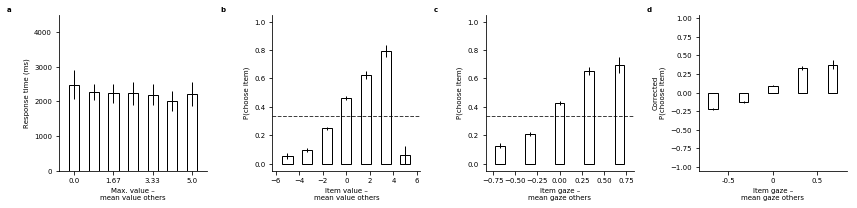

In [5]:
gb.plots.absolute_fit_aggregate(hglam.data);

### Fit GLAM to it

In [6]:
hglam.make_model(kind='hierarchical')

Generating hierarchical model for 20 subjects...


/Users/felixmolter/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/felixmolter/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/felixmolter/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tupl

In [7]:
hglam.fit(method='MCMC', draws=10000, tune=190000, chains=2, cores=8, seed=2)

Fitting 1 model(s) using MCMC...
  Fitting model 1 of 1...


/Users/felixmolter/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/felixmolter/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/felixmolter/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tupl

/!\ Automatically setting parameter precision...


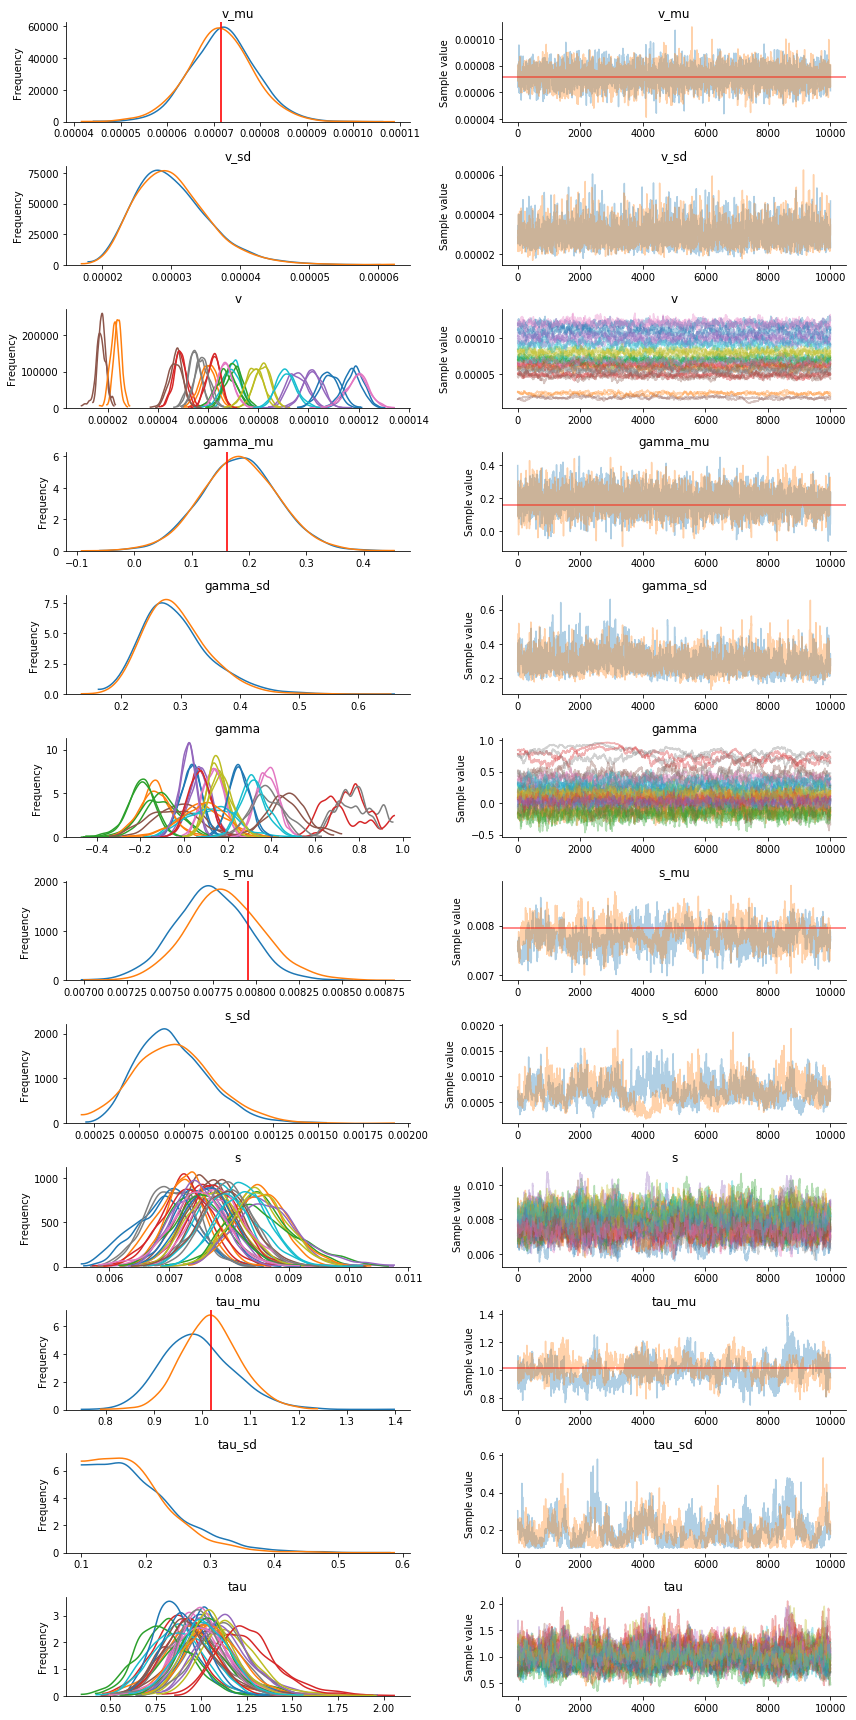

In [8]:
pm.traceplot(hglam.trace[0],
             varnames=['v_mu', 'v_sd', 'v',
                       'gamma_mu', 'gamma_sd', 'gamma',
                       's_mu', 's_sd', 's',
                       'tau_mu', 'tau_sd', 'tau'],
             lines=dict(v_mu=hglam.parameters['condition_0']['v'].mean(),
                        gamma_mu=hglam.parameters['condition_0']['gamma'].mean(),
                        s_mu=hglam.parameters['condition_0']['s'].mean(),
                        tau_mu=hglam.parameters['condition_0']['tau'].mean())
             );

### Create model-generated, synthetic dataset using real stimulus & gaze data and estimated model parameters

In [9]:
hglam.predict(n_repeats=1)
synthetic = hglam.prediction

  0%|          | 0/2000 [00:00<?, ?it/s]

Generating predictions for 2000 trials (1 repeats each)...


100%|██████████| 2000/2000 [00:14<00:00, 138.86it/s]


### Fit GLAM to synthetic dataset

In [10]:
hglam_rec = gb.GLAM(data=synthetic)
hglam_rec.make_model(kind='hierarchical')
hglam_rec.fit(method='MCMC', draws=10000, tune=190000, cores=8, chains=2, seed=3)

Generating hierarchical model for 20 subjects...


/Users/felixmolter/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


Fitting 1 model(s) using MCMC...
  Fitting model 1 of 1...


Multiprocess sampling (2 chains in 8 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [tau_sd]
>Metropolis: [tau_mu]
>Metropolis: [s]
>Metropolis: [s_sd]
>Metropolis: [s_mu]
>Metropolis: [gamma]
>Metropolis: [gamma_sd]
>Metropolis: [gamma_mu]
>Metropolis: [v]
>Metropolis: [v_sd]
>Metropolis: [v_mu]
Sampling 2 chains: 100%|██████████| 400000/400000 [1:04:45<00:00, 102.95draws/s]
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


/!\ Automatically setting parameter precision...


### Compare generating and recovered parameters

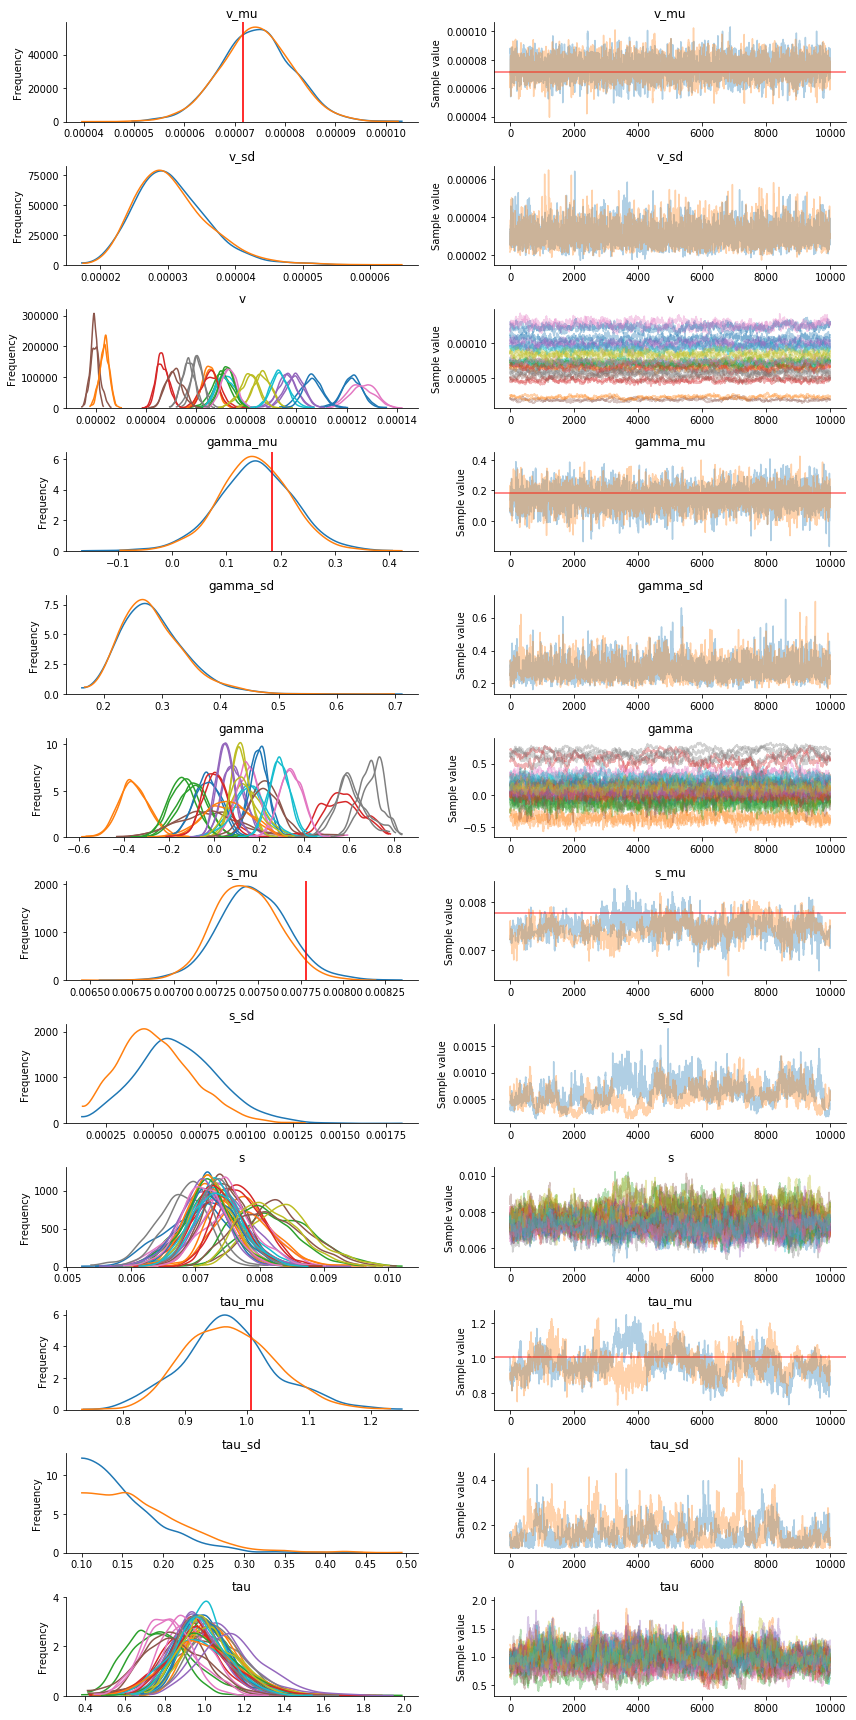

In [11]:
pm.traceplot(hglam_rec.trace[0],
             varnames=['v_mu', 'v_sd', 'v',
                       'gamma_mu', 'gamma_sd', 'gamma',
                       's_mu', 's_sd', 's',
                       'tau_mu', 'tau_sd', 'tau'],
             lines=dict(v_mu=hglam.estimates['v_mu'].mean(),
                        gamma_mu=hglam.estimates['gamma_mu'].mean(),
                        s_mu=hglam.estimates['s_mu'].mean(),
                        tau_mu=hglam.estimates['tau_mu'].mean())
             );

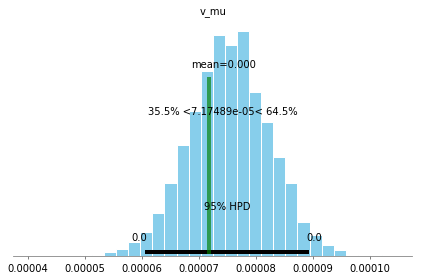

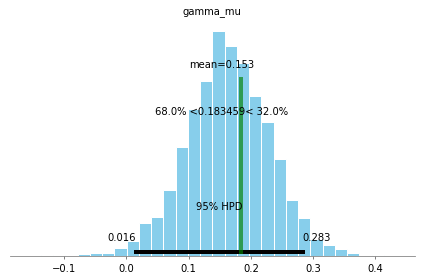

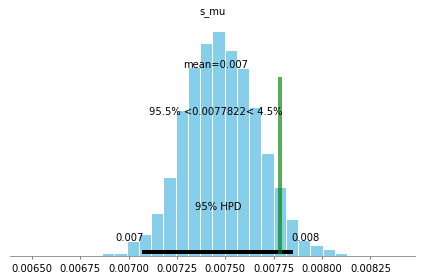

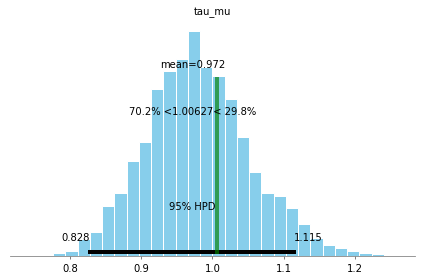

In [12]:
pm.plot_posterior(hglam_rec.trace[0], varnames=['v_mu'], ref_val=hglam.estimates['v_mu'].mean());
pm.plot_posterior(hglam_rec.trace[0], varnames=['gamma_mu'], ref_val=hglam.estimates['gamma_mu'].mean());
pm.plot_posterior(hglam_rec.trace[0], varnames=['s_mu'], ref_val=hglam.estimates['s_mu'].mean());
pm.plot_posterior(hglam_rec.trace[0], varnames=['tau_mu'], ref_val=hglam.estimates['tau_mu'].mean());

# Conclusion

In this example, we demonstrated how to perform a basic parameter recovery for a given dataset. When successful, this increases confidence that the parameters can be identified with the given data set and that the obtained parameter estimates are the true generating parameters.